**DISCLAIMER**

By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code (1) is not subject to SOC 1 and SOC 2 compliance audits, and (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional. Do not use this code to replace, substitute, or provide professional financial advice, or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part.

# ESG - reports

The future of finance goes hand in hand with social responsibility, environmental stewardship and corporate ethics. In order to stay competitive, Financial Services Institutions (FSI)  are increasingly  disclosing more information about their **environmental, social and governance** (ESG) performance. By better understanding and quantifying the sustainability and societal impact of any investment in a company or business, FSIs can mitigate reputation risk and maintain the trust with both their clients and shareholders. At Databricks, we increasingly hear from our customers that ESG has become a C-suite priority. This is not solely driven by altruism but also by economics: [Higher ESG ratings are generally positively correlated with valuation and profitability while negatively correlated with volatility](https://corpgov.law.harvard.edu/2020/01/14/esg-matters/). In this demo, we offer a novel approach to sustainable finance by combining NLP techniques and graph analytics to extract key strategic ESG initiatives and learn companies' relationships in a global market and their impact to market risk calculations.

---
+ <a href="https://databricks.com/notebooks/esg_notebooks/01_esg_report.html">STAGE1</a>: Using NLP to extract key ESG initiatives PDF reports
+ <a href="https://databricks.com/notebooks/esg_notebooks/02_esg_scoring.html">STAGE2</a>: Introducing a novel approach to ESG scoring using graph analytics
+ <a href="https://databricks.com/notebooks/esg_notebooks/03_esg_market.html">STAGE3</a>: Applying ESG to market risk calculations
---

## Context
Financial services organisations are now facing more and more pressure from their shareholders to disclose more information about their environmental, social and governance strategies. Typically released on their websites on a yearly basis as a form of a PDF document, companies communicate on their key ESG initiatives across multiple themes such as how they value their employees, clients or customers, how they positively contribute back to society or even how they reduce  (or commit to reduce) their carbon emissions. Consumed by third parties agencies (such as [msci](https://www.msci.com/esg-ratings) or [csrhub](https://www.csrhub.com/)), these reports are usually consolidated and benchmarked across industries to create ESG metrics. In this notebook, we would like to programmatically access 40+ ESG reports from top tier financial services institutions and learn key ESG initiatives across different topics

### Dependencies
As reported in below cell, we use multiple 3rd party libraries that must be made available across Spark cluster. **NOTE** The next cell assumes you are running this notebook on a Databricks cluster that does not make use of the ML runtime.  If using an ML runtime, please follow these [alternative steps](https://docs.databricks.com/libraries.html#workspace-library) to load libraries to your environment.

In [ ]:
dbutils.library.installPyPI('PyPDF2')
dbutils.library.installPyPI('spacy')
dbutils.library.installPyPI('gensim')
dbutils.library.installPyPI('wordcloud')
dbutils.library.installPyPI('mlflow')
dbutils.library.restartPython()

In [ ]:
%sql
--DO NOT CREATE IF ALREADY EXISTS
CREATE DATABASE esg_db;

In [ ]:
import warnings
import requests
import PyPDF2
import io
import re
import string
import pandas as pd
import numpy as np
import gensim
import spacy
from spacy import displacy
import uuid
import os
import json

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans

from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

warnings.simplefilter("ignore", DeprecationWarning)
%matplotlib inline

/local_disk0/pythonVirtualEnvDirs/virtualEnv-1f44f2ec-2f71-4229-81e9-cdab2f26387a/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
 warnings.warn(msg)

## `STEP1`: Extract ESG reports
In this section, we manually search for publicly available ESG reports from top tier FSIs. As of today, I am not aware of any central repository that would consolidate all these reports across companies and industries, so we have to provide all URLs to download ESG reports from for specific companies. As all PDFs may be of different formats, we have to spend a lot of time consolidating reports into well defined statements, then extracting grammatically valid sentences using `spacy`. Although our dataset is relatively small, loading and executing spacy models is an expensive process. We leverage the `pandasUDF` paradigm to load models only once so that our process can easily scale for a larger collection of ESG documents across all your investments.

In [ ]:
esg_urls_rows = [
  ['barclays', 'https://home.barclays/content/dam/home-barclays/documents/citizenship/ESG/Barclays-PLC-ESG-Report-2019.pdf'],
  ['jp morgan chase', 'https://impact.jpmorganchase.com/content/dam/jpmc/jpmorgan-chase-and-co/documents/jpmc-cr-esg-report-2019.pdf'],
  ['morgan stanley', 'https://www.morganstanley.com/pub/content/dam/msdotcom/sustainability/Morgan-Stanley_2019-Sustainability-Report_Final.pdf'],
  ['goldman sachs', 'https://www.goldmansachs.com/what-we-do/sustainable-finance/documents/reports/2019-sustainability-report.pdf'],
  ['hsbc', 'https://www.hsbc.com/-/files/hsbc/our-approach/measuring-our-impact/pdfs/190408-esg-update-april-2019-eng.pdf'],
  ['citi', 'https://www.citigroup.com/citi/about/esg/download/2019/Global-ESG-Report-2019.pdf'],
  ['td bank', 'https://www.td.com/document/PDF/corporateresponsibility/2018-ESG-Report.pdf'],
  ['bank of america', 'https://about.bankofamerica.com/assets/pdf/Bank-of-America-2017-ESG-Performance-Data-Summary.pdf'],
  ['rbc', 'https://www.rbc.com/community-social-impact/_assets-custom/pdf/2019-ESG-Report.PDF'],
  ['macquarie', 'https://www.macquarie.com/assets/macq/investor/reports/2020/sections/Macquarie-Group-FY20-ESG.pdf'],
  ['lloyds', 'https://www.lloydsbankinggroup.com/assets/pdfs/who-we-are/responsible-business/downloads/2021feb-lbg-esg-investor-presentation.pdf'],
  ['santander', 'https://www.santander.co.uk/assets/s3fs-public/documents/2019_santander_esg_supplement.pdf'],
  ['bluebay', 'https://www.bluebay.com/globalassets/documents/bluebay-annual-esg-investment-report-2018.pdf'],
  ['lasalle', 'https://www.lasalle.com/documents/ESG_Policy_2019.pdf'],
  ['riverstone', 'https://www.riverstonellc.com/media/1196/riverstone_esg_report.pdf'],
  ['aberdeen standard', 'https://www.standardlifeinvestments.com/RI_Report.pdf'],
  ['apollo', 'https://www.apollo.com/~/media/Files/A/Apollo-V2/documents/apollo-2018-esg-summary-annual-report.pdf'],
  ['bmogan', 'https://www.bmogam.com/gb-en/intermediary/wp-content/uploads/2019/02/cm16148-esg-profile-and-impact-report-2018_v33_digital.pdf'],
  ['vanguard', 'https://personal.vanguard.com/pdf/ISGESG.pdf'],
  ['ruffer', 'https://www.ruffer.co.uk/-/media/Ruffer-Website/Files/Downloads/ESG/2018_Ruffer_report_on_ESG.pdf'],
  ['northern trust', 'https://cdn.northerntrust.com/pws/nt/documents/fact-sheets/mutual-funds/institutional/annual-stewardship-report.pdf'],
  ['hermes investments', 'https://www.hermes-investment.com/ukw/wp-content/uploads/sites/80/2017/09/Hermes-Global-Equities-ESG-Dashboard-Overview_NB.pdf'],
  ['abri capital', 'http://www.abris-capital.com/sites/default/files/Abris%20ESG%20Report%202018.pdf'],
  ['schroders', 'https://www.schroders.com/en/sysglobalassets/digital/insights/2019/pdfs/sustainability/sustainable-investment-report/sustainable-investment-report-q2-2019.pdf'],
  ['lazard', 'https://www.lazardassetmanagement.com/docs/-m0-/54142/LazardESGIntegrationReport_en.pdf'],
  ['credit suisse', 'https://www.credit-suisse.com/pwp/am/downloads/marketing/br_esg_capabilities_uk_csam_en.pdf'],
  ['coller capital', 'https://www.collercapital.com/sites/default/files/Coller%20Capital%20ESG%20Report%202019-Digital%20copy.pdf'],
  ['cinven', 'https://www.cinven.com/media/2086/81-cinven-esg-policy.pdf'],
  ['warburg pircus', 'https://www.warburgpincus.com/content/uploads/2019/07/Warburg-Pincus-ESG-Brochure.pdf'],
  ['exponent', 'https://www.exponentpe.com/sites/default/files/2020-01/Exponent%20ESG%20Report%202018.pdf'],
  ['silverfleet capital', 'https://www.silverfleetcapital.com/media-centre/silverfleet-esg-report-2020.pdf'],
  ['kkr', 'https://www.kkr.com/_files/pdf/KKR_2018_ESG_Impact_and_Citizenship_Report.pdf'],
  ['cerberus', 'https://www.cerberus.com/media/2019/07/Cerberus-2018-ESG-Report_FINAL_WEB.pdf'],
  ['standard chartered', 'https://av.sc.com/corp-en/others/2018-sustainability-summary2.pdf'],
]

# create a Pandas dataframe of ESG report URLs
esg_urls_pd = pd.DataFrame(esg_urls_rows, columns=['company', 'url'])

# we distribute our small collection across our cluster to...
# ...exploit parallelism when downloading / curating information
esg_urls = spark.createDataFrame(esg_urls_pd).repartition(8)

In [ ]:
@udf('string')
def extract_content(url):
  """
  A simple user define function that, given a url, download PDF text content
  Parse PDF and return plain text version
  """
  try:
    # retrieve PDF binary stream
    response = requests.get(url)
    open_pdf_file = io.BytesIO(response.content)
    pdf = PyPDF2.PdfFileReader(open_pdf_file)  
    # access pdf content
    text = [pdf.getPage(i).extractText() for i in range(0, pdf.getNumPages())]
    # return concatenated content
    return "\n".join(text)
  except:
    return ""
    
# download PDF from ESG reports
esg_articles = esg_urls \
  .withColumn('content', extract_content(F.col('url'))) \
  .filter(F.length(F.col('content')) > 0) \
  .cache()

esg_articles.count()
display(esg_articles)

company url content riverstone https://www.riverstonellc.com/media/1196/riverstone_esg_report.pdf Riverstone ESG Report 2019
INVESTING 
RESPONSIBLY

Founders™ 
 Statement
DRIVING VALUE THROUGH ESG 
Since founding Riverstone, we 
have both been strong believers 
that responsible investing is not 
only the right thing to do, but it 
leads to favorable results over the 
long run. 
Being a trustworthy, fair and 
transparent partner to each of 
our stakeholders builds a strong 
foundation that enables our 
 ˜rm and portfolio companies 
 to succeed. 
For that reason, including 
environmental, social and 
governance (ESG) at each stage 
of our investment and asset 
management processes has 
been and remains a priority 
for
 Riverstone.
As we continue building the 
˜rm, we are pleased to present 
our inaugural ESG Report which 
highlights our ESG philosophy, 
the systems we have in place and 
our objectives for the future. 
AN UNWAVERING DEDICATION
As one of the world™s largest 
energy, power and infrastructure 
investment ˜rms, we have spent 
two decades evolving our ESG 
processes to re˚ect best practices 
that align with our core values. In 
this regard, we have formalized 
our ESG program within our 
organization and across our 
portfolio companies with 
processes that span the entire 
investment lifecycle. 
˛e purpose of this program 
is to manage risks, maximize 
opportunity and ensure 
stakeholder concerns are 
addressed, where possible, 
across
 numerous key ESG factors 
including natural resource 
management, health and safety, 
community and stakeholder 
impact, climate change, 
greenhouse gas emissions and 
governance, among many others.
We believe this steadfast focus on 
ESG helps us make well-informed 
decisions that have a positive 
impact on our companies and 
the environments in which they 
operate, and squarely aligns 
 with the ˜duciary duty we owe 
 to our investors.
LOOKING AHEAD
While we are proud of all the 
progress that we have made, 
managing ESG requires 
continuous focus. As we look 
ahead, we will continue adapting 
and evolving our ESG practices 
to re˚ect the dynamic and ever-
changing world in which we live. 
To us, this report represents 
an important step forward in 
our commitment to corporate 
citizenship and transparency. 
 We hope that you ˜nd it 
informative and look forward to 
providing you with additional 
updates in the future.
˛ank you for your continued 
support. 
Pierre F. Lapeyre, Jr. 
David M. Leuschen 
1
At Riverstone, we always focus on 
ﬁdoing˜things betterﬂ Œ our approach 
to˜ESG is no di˚erent.
ESG at 
Riverstone 
ﬁ ˛e integration of ESG 
considerations throughout 
our operations is core to 
the long-term success of 
our portfolio companies 
and our ˜rm.ﬂ
2
About Our 
 Business 
Founded in 2000, Riverstone is a 
private˜investment ˛rm focused on 

energy, power and infrastructure. 

Our sole mission is to build great 

businesses and deliver strong 

returns˜to our investors.
WHO WE ARE 
Since inception, Riverstone has 
raised over $39 billion of capital 

to invest in all major components 

of our industry™s value chain, both 

globally and across the capital 

structure. We are industry experts 

who provide turnkey investment 

solutions tailored to investors™ 

needs through our platform of 

investment strategies: 
 ŁPrivate Equity
 ŁCredit
 ŁPower, Infrastructure
& Renewables
 ŁLatin America
OUR PHILOSOPHY 
At Riverstone, innovation and 

creativity are fundamental tenets 

that shape the culture we promote 

Œ both at our portfolio companies

and within our own organization. 
We are strong advocates of fresh 
ideas, which we believe enable 

us to always be at the forefront of 

our industry as leaders. ˛is helps 

us adapt quickly to a complex 

and constantly evolving world to 

better serve our stakeholders, 

ranging from investors to 

employees to communities.
KEY STATS
* From inception to December 31, 2019
Portfolio 
Companies
*180
+Capital 

Committed to 

Investments

In [ ]:
def remove_non_ascii(text):
  printable = set(string.printable)
  return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
  # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
  return not line.isupper()

def extract_statements(nlp, text):
  """
  Extracting ESG statements from raw text by removing junk, URLs, etc.
  We group consecutive lines into paragraphs and use spacy to parse sentences.
  """
  
  # remove non ASCII characters
  text = remove_non_ascii(text)
  
  lines = []
  prev = ""
  for line in text.split('\n'):
    # aggregate consecutive lines where text may be broken down
    # only if next line starts with a space or previous does not end with dot.
    if(line.startswith(' ') or not prev.endswith('.')):
        prev = prev + ' ' + line
    else:
        # new paragraph
        lines.append(prev)
        prev = line
        
  # don't forget left-over paragraph
  lines.append(prev)

  # clean paragraphs from extra space, unwanted characters, urls, etc.
  # best effort clean up, consider a more versatile cleaner
  sentences = []
  for line in lines:
    
      # removing header number
      line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
      # removing trailing spaces
      line = line.strip()
      # words may be split between lines, ensure we link them back together
      line = re.sub('\s?-\s?', '-', line)
      # remove space prior to punctuation
      line = re.sub(r'\s?([,:;\.])', r'\1', line)
      # ESG contains a lot of figures that are not relevant to grammatical structure
      line = re.sub(r'\d{5,}', r' ', line)
      # remove mentions of URLs
      line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
      # remove multiple spaces
      line = re.sub('\s+', ' ', line)
      
      # split paragraphs into well defined sentences using spacy
      for part in list(nlp(line).sents):
        sentences.append(str(part).strip())

  return sentences

@pandas_udf('array<string>', PandasUDFType.SCALAR_ITER)
def extract_statements_udf(content_series_iter):
  """
  as loading a spacy model takes time, we certainly do not want to load model for each record to process
  we load model only once and apply it to each batch of content this executor is responsible for
  """
  
  # load spacy model
  spacy.cli.download("en_core_web_sm")
  nlp = spacy.load("en_core_web_sm", disable=['ner'])
  
  # cleanse and tokenize a batch of PDF content 
  for content_series in content_series_iter:
    yield content_series.map(lambda x: extract_statements(nlp, x))

# *****************************
# apply transformation at scale
# *****************************

esg_statements = esg_articles \
  .withColumn('statements', extract_statements_udf(F.col('content'))) \
  .withColumn('statement', F.explode(F.col('statements'))) \
  .filter(F.length(F.col('statement')) > 100) \
  .select('company', 'statement') \
  .cache()

esg_statements.count()
display(esg_statements)

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
 "in the future releases. See SPARK-28264 for more details.", UserWarning)

company statement riverstone Riverstone ESG Report 2019 INVESTING RESPONSIBLY Founders Statement DRIVING VALUE THROUGH ESG Since founding Riverstone, we have both been strong believers that responsible investing is not only the right thing to do, but it leads to favorable results over the long run. riverstone Being a trustworthy, fair and transparent partner to each of our stakeholders builds a strong foundation that enables our rm and portfolio companies to succeed. riverstone For that reason, including environmental, social and governance (ESG) at each stage of our investment and asset management processes has been and remains a priority for Riverstone. riverstone As we continue building the rm, we are pleased to present our inaugural ESG Report which highlights our ESG philosophy, the systems we have in place and our objectives for the future. riverstone As one of the worlds largest energy, power and infrastructure investment rms, we have spent two decades evolving our ESG processes to reect best practices that align with our core values. riverstone In this regard, we have formalized our ESG program within our organization and across our portfolio companies with processes that span the entire investment lifecycle. riverstone e purpose of this program is to manage risks, maximize opportunity and ensure stakeholder concerns are addressed, where possible, across numerous key ESG factors including natural resource management, health and safety, community and stakeholder impact, climate change, greenhouse gas emissions and governance, among many others. riverstone We believe this steadfast focus on ESG helps us make well-informed decisions that have a positive impact on our companies and the environments in which they operate, and squarely aligns with the duciary duty we owe to our investors. riverstone LOOKING AHEAD While we are proud of all the progress that we have made, managing ESG requires continuous focus. riverstone As we look ahead, we will continue adapting and evolving our ESG practices to reect the dynamic and ever-changing world in which we live. riverstone To us, this report represents an important step forward in our commitment to corporate citizenship and transparency. riverstone We hope that you nd it informative and look forward to providing you with additional updates in the future. riverstone ESG at Riverstone e integration of ESG considerations throughout our operations is core to the long-term success of our portfolio companies and our rm. riverstone About Our Business Founded in 2000, Riverstone is a privateinvestment rm focused on energy, power and infrastructure. riverstone WHO WE ARE Since inception, Riverstone has raised over $39 billion of capital to invest in all major components of our industrys value chain, both globally and across the capital structure. riverstone We are industry experts who provide turnkey investment solutions tailored to investors needs through our platform of investment strategies: Private Equity Credit Power, Infrastructure & Renewables riverstone Latin America OUR PHILOSOPHY At Riverstone, innovation and creativity are fundamental tenets that shape the culture we promote both at our portfolio companies and within our own organization. riverstone We are strong advocates of fresh ideas, which we believe enable us to always be at the forefront of our industry as leaders. riverstone is helps us adapt quickly to a complex and constantly evolving world to better serve our stakeholders, ranging from investors to employees to communities. riverstone From inception to December 31, 2019 Portfolio Companies *180 +Capital Committed to Investments *$40 B 1 Rest of World includes investments in Africa, Asia, South America, Australia and investments classied as Global by Riverstone. riverstone Oces Globally 5Employees 120 + Countries Invested In *11London New York Mexico City U.S. ONSHORE GULF OF MEXICO Amsterdam RIVERSTONE OFFICES 133 investments $23.0 billion committed 57% of commitments 

In [ ]:
#tokenizing sentences using a custom function
def tokenize(sentence):
  gen = gensim.utils.simple_preprocess(sentence, deacc=True)
  return ' '.join(gen)

#lemmatizing generated tokens to reduce them to root words,
#Uses the above function
def lemmatize(nlp, text):
  
  # parse sentence using spacy
  doc = nlp(text) 
  
  # convert words into their simplest form (singular, present form, etc.)
  lemma = []
  for token in doc:
      if (token.lemma_ not in ['-PRON-']):
          lemma.append(token.lemma_)
          
  return tokenize(' '.join(lemma))

@pandas_udf('string', PandasUDFType.SCALAR_ITER)
def lemma(content_series_iter):
  """
  as loading a spacy model takes time, we certainly do not want to load model for each record to process
  we load model only once and apply it to each batch of content this executor is responsible for
  """

  # load spacy model
  spacy.cli.download("en_core_web_sm")
  nlp = spacy.load("en_core_web_sm", disable=['ner'])
  
  # lemmatize a batch of text content into sentences
  for content_series in content_series_iter:
    yield content_series.map(lambda x: lemmatize(nlp, x))
    
# *****************************
# apply transformation at scale
# *****************************

esg_lemma = esg_statements \
  .withColumn('lemma', lemma(F.col('statement'))) \
  .select('company', 'statement', 'lemma')

display(esg_lemma)

company statement lemma riverstone Riverstone ESG Report 2019 INVESTING RESPONSIBLY Founders Statement DRIVING VALUE THROUGH ESG Since founding Riverstone, we have both been strong believers that responsible investing is not only the right thing to do, but it leads to favorable results over the long run. riverstone esg report investing responsibly founder statement driving value through esg since found riverstone we have both be strong believer that responsible investing be not only the right thing to do but it lead to favorable result over the long run riverstone Being a trustworthy, fair and transparent partner to each of our stakeholders builds a strong foundation that enables our rm and portfolio companies to succeed. be trustworthy fair and transparent partner to each of our stakeholder build strong foundation that enable our rm and portfolio company to succeed riverstone For that reason, including environmental, social and governance (ESG) at each stage of our investment and asset management processes has been and remains a priority for Riverstone. for that reason include environmental social and governance esg at each stage of our investment and asset management process have be and remain priority for riverstone riverstone As we continue building the rm, we are pleased to present our inaugural ESG Report which highlights our ESG philosophy, the systems we have in place and our objectives for the future. as we continue build the rm we be pleased to present our inaugural esg report which highlight our esg philosophy the system we have in place and our objective for the future riverstone As one of the worlds largest energy, power and infrastructure investment rms, we have spent two decades evolving our ESG processes to reect best practices that align with our core values. as one of the world large energy power and infrastructure investment rm we have spend two decade evolve our esg process to reect good practice that align with our core value riverstone In this regard, we have formalized our ESG program within our organization and across our portfolio companies with processes that span the entire investment lifecycle. in this regard we have formalize our esg program within our organization and across our portfolio company with process that span the entire investment lifecycle riverstone e purpose of this program is to manage risks, maximize opportunity and ensure stakeholder concerns are addressed, where possible, across numerous key ESG factors including natural resource management, health and safety, community and stakeholder impact, climate change, greenhouse gas emissions and governance, among many others. purpose of this program be to manage risk maximize opportunity and ensure stakeholder concern be address where possible across numerous key esg factor include natural resource management health and safety community and stakeholder impact climate change greenhouse gas emission and governance among many other riverstone We believe this steadfast focus on ESG helps us make well-informed decisions that have a positive impact on our companies and the environments in which they operate, and squarely aligns with the duciary duty we owe to our investors. we believe this steadfast focus on esg help we make well inform decision that have positive impact on our company and the environment in which they operate and squarely align with the duciary duty we owe to our investor riverstone LOOKING AHEAD While we are proud of all the progress that we have made, managing ESG requires continuous focus. look ahead while we be proud of all the progress that we have make manage esg require continuous focus riverstone As we look ahead, we will continue adapting and evolving our ESG practices to reect the dynamic and ever-changing world in which we live. as we look ahead we will continue adapt and evolve our esg practice to reect the dynamic and ever change world in which we live riverstone To us, this report represents an important step for

In [ ]:
e_df = esg_lemma.filter(F.col('company') =='lloyds')
display(e_df)

company statement lemma lloyds Investor Relations, February 2021 ESG Investor Presentation Our Lloyds Banking Group ESG Report 2020 is available on our Group webpage here Our ESG priorities and Strategic Review 2021 2 9 Environmental matters 10 15 Social matters 16 24 Governance matters 25 30 Contents 1 Multi-brand, multi-channel digital bank and branch network Comprehensive product range with all financial needs served in one place; banking, insurance and wealth management Differentiated and sustainable customer franchise with integrated propositions; 25m customers, >17m digitally active Market leading efficiency through tech-enabled productivity improvements, enabling us to invest more Prudent, low-risk business with strong capital position Purpose-driven company with clear focus on supporting the UK, through an inclusive and diverse organisation Lloyds Banking Group is a unique integrated UK financial services leader Customer focused, sustainable, efficient and low risk UK financial services leader 2 3 Our Approach to ESG Embracing our responsibility to help address some of the social, economic and environmental challenges ESG performance integral to delivery of our purpose, strategy and societal goals Support the UN Sustainable Development Goals ESG metrics included in the Group balanced scorecard Our Purpose Clear purpose of Helping Britain Prosper Focus evolving in response to the pandemic investor relations february esg investor presentation our lloyds banking group esg report be available on our group webpage here our esg priority and strategic review environmental matter social matter governance matter contents multi brand multi channel digital bank and branch network comprehensive product range with all financial need serve in one place banking insurance and wealth management differentiate and sustainable customer franchise with integrate proposition customer digitally active market lead efficiency through tech enable productivity improvement enable we to invest more prudent low risk business with strong capital position purpose drive company with clear focus on support the uk through an inclusive and diverse organisation lloyds banking group be unique integrate uk financial service leader customer focus sustainable efficient and low risk uk financial service leader our approach to esg embrace our responsibility to help address some of the social economic and environmental challenge esg performance integral to delivery of our purpose strategy and societal goal support the un sustainable development goals esg metric include in the group balanced scorecard our purpose clear purpose of help britain prosper focus evolve in response to the pandemic lloyds In the near term this will be to Help Britain Recover Embedded in our business and in the best interest of all stakeholders The first bank to launch such a plan Addressing some of the environmental, economic and social challenges the UK faces is the foundation of the Plan Focus on key identified areas of societal benefit where we can make the biggest difference Group balanced scorecard since 2018 Our Helping Britain Prosper Plan has underpinned our ESG priorities Tackling social disadvantage across Britain c.2,800 charities supported Building capability and digital skills 1.8m individuals, charities and SMEs trained in digital skills Supporting businesses to start up and grow >6bn increase in net lending to start-ups/SME/MM businesses Helping people save for the future 46bn increase in AUA in retirement and investment products in the near term this will be to help britain recover embed in our business and in the good interest of all stakeholder the first bank to launch such plan address some of the environmental economic and social challenge the uk face be the foundation of the plan focus on key identify area of societal benefit where we can make the big difference group balanced scorecard since our help britain prosper plan have underpin our esg priority tackle social d

In [ ]:
#Company wise esg statements to get a specific wordcloud
esg = esg_lemma.select("company", "statement", "lemma").toPandas()
esg_grouped = esg.groupby("company")


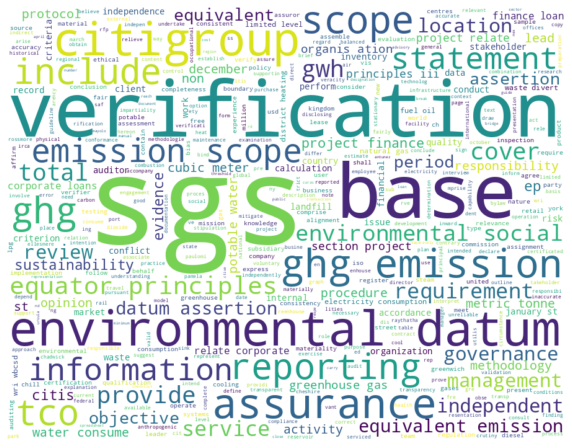

In [ ]:
organisation = "barclays"
barclays_lemmas = esg_grouped.get_group(organisation)[['company','lemma']]
large_string = ' '.join(barclays_lemmas.lemma)

# context specific keywords not to include in topic modelling
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make'
]

# add company names as stop words
for fsi in [row[0] for row in esg_urls_rows]:
    for t in fsi.split(' '):
        fsi_stop_words.append(t)

# our list contains all english stop words + companies names + specific keywords
stop_words = text.ENGLISH_STOP_WORDS.union(fsi_stop_words)
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
%python
from pyspark.sql.functions import *
#Saving required dataframe data to intermediary source table
barclays_lemmas_df = spark.createDataFrame(barclays_lemmas)
barclays_lemmas_df \
.write\
.mode("append")\
.format("delta")\
.saveAsTable("esg_db.srcEsgOrgWordCloudData")

In [ ]:
%sql
Select DISTINCT Company from esg_db.srcEsgOrgWordCloudData

Company goldman sachs jp morgan chase morgan stanley macquarie santander barclays citi

In [ ]:
%scala
import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger

//read data from source table
//create a streaming dataframe to store data in an intermediate table
val streamDf = spark 
  .readStream                                                    // Reading as a stream, processing record since last check point
  .format("delta")                                              // Reading from a delta table
  .table("esg_db.srcEsgOrgWordCloudData")                      //Main source table
  .withColumn("IsMigrated", lit(0))                           //IsMigrated helps us keep a check on the data that we have already migrated, therefore minimizing redundant pulling of data

//Create a chekpoint of last insertion
//checkpoint makes sure that the only the changes in the source data, if any, will be stored in intermediate data
streamDf
  .writeStream                                                                                // Writing data as a stream
  .trigger(Trigger.Once)                                                                     // Create a streaming job triggered only once...
  .option("checkpointLocation", "/esg_checkpoint/dbrEsgOrgWordCloudData_4")                 //Don't change checkpoint location (processes data since last checkpoint)
  .format("delta")                                                                         // write to delta table
  .table("esg_db.dbrEsgOrgWordCloudData")                                                 //Save to intermediary Databricks table

import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger
streamDf: org.apache.spark.sql.DataFrame = [company: string, lemma: string ... 1 more field]
res1: org.apache.spark.sql.streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@5e6052ae

In [ ]:
%sql
SELECT DISTINCT Company, IsMigrated FROM esg_db.dbrEsgOrgWordCloudData 


In [ ]:
%scala
//Configuration settings to connect to blob storage
//spark.conf.set("fs.azure.account.key.#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net","#STORAGE_ACCOUNT_KEY#"))

//declaring the credentials
//val sqluser =  dbutils.secrets.get(scope="esgmigratecreds", key="sqluser")
//val sqlpassword = dbutils.secrets.get(scope="esgmigratecreds", key="sqlpassword")
//val dbtable = "ADB_EsgOrgWordCloudData" //Synapse Table Name Set here
//val url = s"jdbc:sqlserver://#WORKSPACE_NAME#.sql.azuresynapse.net:1433;database=#DATABASE_NAME#;user=#SQL_USERNAME#;password=#SQL_PASSWORD#;encrypt=true;trustServerCertificate=true;hostNameInCertificate=*.sql.azuresynapse.net;loginTimeout=30;authentication=ActiveDirectoryPassword"

// //Read only newer records from our intermediary table in Databricks
// var migrate_df = spark.sql("SELECT Company as Organisation, Lemma, current_timestamp() as ReportedOn FROM esg_db.dbrEsgOrgWordCloudData WHERE IsMigrated = 0")
 
// print(s"Total Records", migrate_df.count())
// print("\n")

// //Send new records to synapse for further processing
// migrate_df.write.format("com.databricks.spark.sqldw").option("forwardSparkAzureStorageCredentials", "true").mode("append").option("url", url).option("dbtable", dbtable).option("tempDir", "abfss://esg-migrate@stfsimarketdatasynprod.dfs.core.windows.net/tempDirs").save()

// //Mark records as migrated after successfully saved to synapase
// spark.sql("UPDATE esg_db.dbrEsgOrgWordCloudData SET IsMigrated = 1 WHERE IsMigrated = 0")

## `STEP2`: Topic modelling
Once cleansed, our dataset only contains well defined ESG statements and therefore easily fits in memory (our corpus is ~ 7,200 large). We convert our collection back to pandas dataframe to use native python and visualisations. A first approach will always be to look at term frequency (and inverse document frequency - see [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) for ngram analysis. By adding stop words that we know are domain specifics (such as bank, plc, inc.), we can easily see relevant words using simple graph or wordclouds.

In [ ]:
esg = esg_lemma.select("company", "statement", "lemma").toPandas()

In [ ]:
display(esg_lemma)

company statement lemma riverstone Riverstone ESG Report 2019 INVESTING RESPONSIBLY Founders Statement DRIVING VALUE THROUGH ESG Since founding Riverstone, we have both been strong believers that responsible investing is not only the right thing to do, but it leads to favorable results over the long run. riverstone esg report investing responsibly founder statement driving value through esg since found riverstone we have both be strong believer that responsible investing be not only the right thing to do but it lead to favorable result over the long run riverstone Being a trustworthy, fair and transparent partner to each of our stakeholders builds a strong foundation that enables our rm and portfolio companies to succeed. be trustworthy fair and transparent partner to each of our stakeholder build strong foundation that enable our rm and portfolio company to succeed riverstone For that reason, including environmental, social and governance (ESG) at each stage of our investment and asset management processes has been and remains a priority for Riverstone. for that reason include environmental social and governance esg at each stage of our investment and asset management process have be and remain priority for riverstone riverstone As we continue building the rm, we are pleased to present our inaugural ESG Report which highlights our ESG philosophy, the systems we have in place and our objectives for the future. as we continue build the rm we be pleased to present our inaugural esg report which highlight our esg philosophy the system we have in place and our objective for the future riverstone As one of the worlds largest energy, power and infrastructure investment rms, we have spent two decades evolving our ESG processes to reect best practices that align with our core values. as one of the world large energy power and infrastructure investment rm we have spend two decade evolve our esg process to reect good practice that align with our core value riverstone In this regard, we have formalized our ESG program within our organization and across our portfolio companies with processes that span the entire investment lifecycle. in this regard we have formalize our esg program within our organization and across our portfolio company with process that span the entire investment lifecycle riverstone e purpose of this program is to manage risks, maximize opportunity and ensure stakeholder concerns are addressed, where possible, across numerous key ESG factors including natural resource management, health and safety, community and stakeholder impact, climate change, greenhouse gas emissions and governance, among many others. purpose of this program be to manage risk maximize opportunity and ensure stakeholder concern be address where possible across numerous key esg factor include natural resource management health and safety community and stakeholder impact climate change greenhouse gas emission and governance among many other riverstone We believe this steadfast focus on ESG helps us make well-informed decisions that have a positive impact on our companies and the environments in which they operate, and squarely aligns with the duciary duty we owe to our investors. we believe this steadfast focus on esg help we make well inform decision that have positive impact on our company and the environment in which they operate and squarely align with the duciary duty we owe to our investor riverstone LOOKING AHEAD While we are proud of all the progress that we have made, managing ESG requires continuous focus. look ahead while we be proud of all the progress that we have make manage esg require continuous focus riverstone As we look ahead, we will continue adapting and evolving our ESG practices to reect the dynamic and ever-changing world in which we live. as we look ahead we will continue adapt and evolve our esg practice to reect the dynamic and ever change world in which we live riverstone To us, this report represents an important step for

In [ ]:
# context specific keywords not to include in topic modelling
fsi_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make'
]

# add company names as stop words
for fsi in [row[0] for row in esg_urls_rows]:
    for t in fsi.split(' '):
        fsi_stop_words.append(t)

# our list contains all english stop words + companies names + specific keywords
stop_words = text.ENGLISH_STOP_WORDS.union(fsi_stop_words)

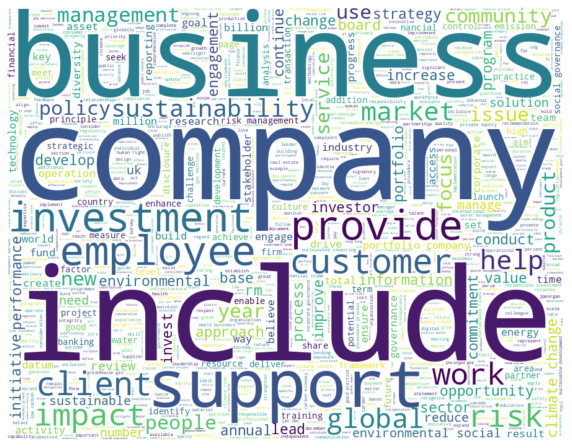

In [ ]:
# aggregate all 7200 records into one large string to run wordcloud on term frequency
# we could leverage spark framework for TF analysis and call wordcloud.generate_from_frequencies instead
large_string = ' '.join(esg.lemma)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

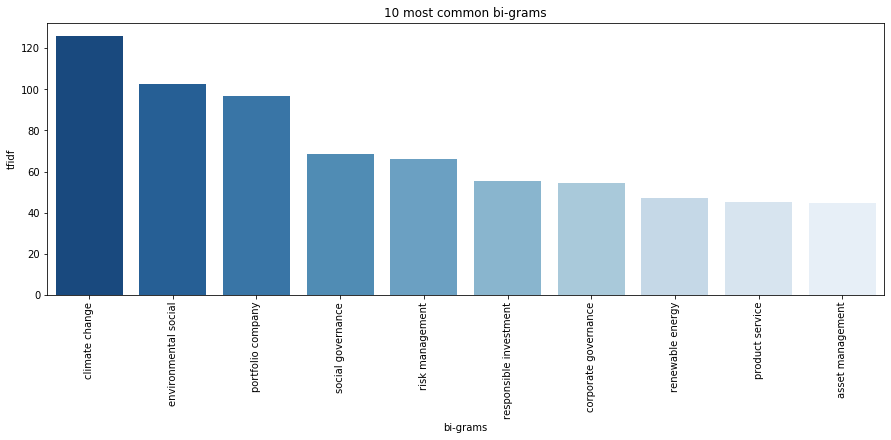

In [ ]:
# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(esg.lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(15, 5))
plt.subplot(title='10 most common bi-grams')
sns.barplot(x_pos, counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('bi-grams')
plt.ylabel('tfidf')
plt.show()


Using TF-IDF, we can observe a strong focus on "climate change" for most of the organisations. Interestingly, ESG comes hand in hand with risk management as well, our top 4 extracted bigram. We've evaluated multiple approaches using either [non negative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) or [latent dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), with TF-IDF and TF respectively. Our experiments indicate 9 topics as descriptive to our corpus documents. We use off the shelf sklearn version of `LatentDirichletAllocation` to learn topics from ESG documents, all topics being described by keywords we can manually sumarize into a specific theme (such as 'valuing employees')

In [ ]:
# Compare to NMF, LDA would not require inverse document frequency as it will learn probability distribution of term frequencies
word_tf_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))
word_tf = word_tf_vectorizer.fit_transform(esg.lemma)

# serialize stopwords
json_data = json.dumps([a for a in stop_words], indent=2)
f = open("/tmp/stopwords.json", "w")
f.write(json_data)
f.close()
  
# track experiment on MLflow
with mlflow.start_run(run_name='topic_modelling'):
  
  # Train a LDA model with 9 topics
  lda = LDA(random_state = 42, n_components = 9, learning_decay = .3)
  lda.fit(word_tf)
  
  # Log model 
  mlflow.sklearn.log_model(lda, "model")
  mlflow.log_param('n_components', '9')
  mlflow.log_param('learning_decay', '.3')
  mlflow.log_metric('perplexity', lda.perplexity(word_tf))
  mlflow.log_artifact("/tmp/stopwords.json")
  
  # retrieve run ID to attach topic name later
  lda_run_id = mlflow.active_run().info.run_id

In [ ]:
# Retrieve top N words describing each of our 9 topics
def top_words(model, feature_names, n_top_words):
  rows = []
  for topic_idx, topic in enumerate(model.components_):
    message = ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    rows.append(["Topic #%d: " % (topic_idx + 1), message])
  return pd.DataFrame(rows, columns=['topic', 'keywords'])

# Display topics keywords for inspection and for us to label topics
tf_feature_names = word_tf_vectorizer.get_feature_names()
display(top_words(lda, tf_feature_names, 15))

topic keywords Topic #1: energy, reduce, renewable, company, new, global, include, increase, year, use, carbon, business, sdg, service, emission Topic #2: emission, customer, banking, scope, use, waste, uk, total, datum, ghg, year, reduce, gas, global, million Topic #3: climate, change, company, risk, client, market, impact, customer, financial, investor, environmental, business, corporate, nancial, governance Topic #4: investment, portfolio, company, process, team, review, research, risk, include, customer, business, compliance, issue, policy, use Topic #5: employee, support, people, community, business, work, help, provide, million, nancial, diversity, program, opportunity, development, create Topic #6: company, investment, impact, sustainability, business, governance, asset, investor, client, issue, management, approach, customer, corporate, social Topic #7: risk, management, environmental, climate, board, social, governance, committee, include, policy, company, business, performance, sector, change Topic #8: statement, information, include, governance, code, principles, environmental, relate, reporting, policy, company, conduct, sustainability, financial, social Topic #9: sustainable, green, investment, fund, billion, sustainability, asset, bond, market, support, finance, growth, investing, nance, energy

With the description of topics extracted from LDA model, we manually name these as follows. This will be used throughout the rest of the demo as a way to compare organisations based on their ESG statements.

In [ ]:
# We estimated our topics to be described around the following themes
topic_names = [
  'green energy',
   'value employees',
  'company transformation',
  'sustainable finance',
  'ethical investments',
  'strong governance', 
   'support community',
  'code of conduct',
  'focus customer'
]

# serialize topic names
json_data = json.dumps(topic_names, indent=2)
f = open("/tmp/topics.json", "w")
f.write(json_data)
f.close()

# attach topics name to LDA model on mlflow
# we do not wish to re-open run_id and therefore alter start / end time
# instead, we log artifact to existing run
client = mlflow.tracking.MlflowClient()
client.log_artifact(lda_run_id, "/tmp/topics.json")

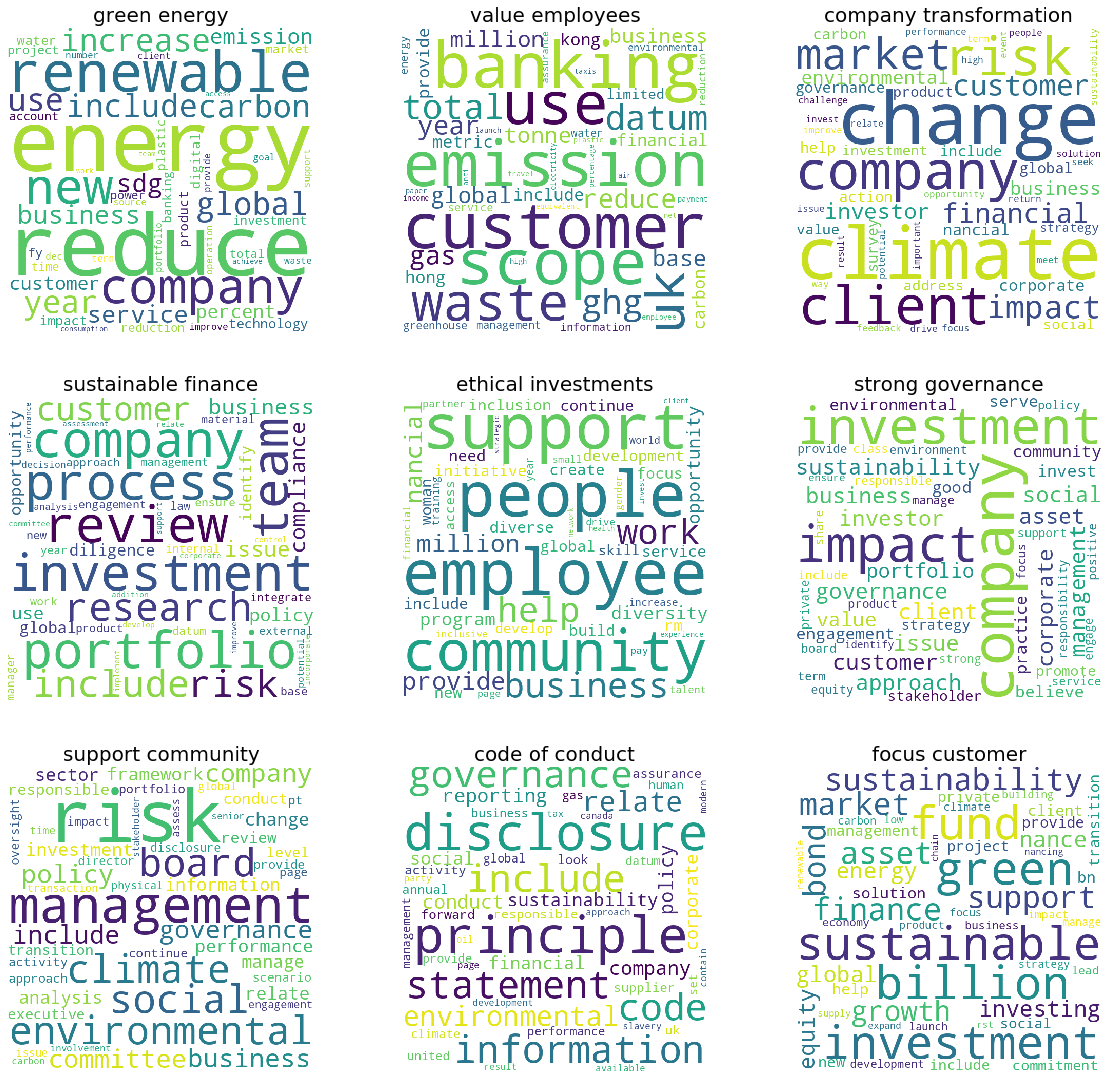

In [ ]:
# We ensure relevance of our topics using simple wordcloud visualisation
def word_cloud(model, tf_feature_names, index):
    
    imp_words_topic=""
    comp = model.components_[index]
    vocab_comp = zip(tf_feature_names, comp)
    sorted_words = sorted(vocab_comp, key = lambda x:x[1], reverse=True)[:50]
    
    for word in sorted_words:
        imp_words_topic = imp_words_topic + " " + word[0]
    
    return WordCloud(
        background_color="white",
        width=600, 
        height=600, 
        contour_width=3, 
        contour_color='steelblue'
    ).generate(imp_words_topic)
    
topics = len(lda.components_)
fig = plt.figure(figsize=(20, 20 * topics / 3))

# Display wordcloud for each extracted topic
for i, topic in enumerate(lda.components_):
    ax = fig.add_subplot(topics, 3, i + 1)
    ax.set_title(topic_names[i], fontsize=20)
    wordcloud = word_cloud(lda, tf_feature_names, i)
    ax.imshow(wordcloud)
    ax.axis('off')

In [ ]:
# score our original dataset to attach topic distribution to each ESG statement
transformed = lda.transform(word_tf)

# find principal topic from distribution...
a = [topic_names[np.argmax(distribution)] for distribution in transformed]

# ... with associated probability
b = [np.max(distribution) for distribution in transformed]

# consolidate LDA output into a handy dataframe 
df1 = esg[['company', 'lemma', 'statement']]
df2 = pd.DataFrame(zip(a,b,transformed), columns=['topic', 'probability', 'probabilities'])
esg_group = pd.concat([df1, df2], axis=1)

# display dataframe
display(esg_group[['company', 'lemma', 'topic', 'probability']])

company lemma topic probability riverstone riverstone esg report investing responsibly founder statement driving value through esg since found riverstone we have both be strong believer that responsible investing be not only the right thing to do but it lead to favorable result over the long run code of conduct 0.5113095552649942 riverstone be trustworthy fair and transparent partner to each of our stakeholder build strong foundation that enable our rm and portfolio company to succeed strong governance 0.5067516679295941 riverstone for that reason include environmental social and governance esg at each stage of our investment and asset management process have be and remain priority for riverstone strong governance 0.9315964382065905 riverstone as we continue build the rm we be pleased to present our inaugural esg report which highlight our esg philosophy the system we have in place and our objective for the future sustainable finance 0.4782196123061864 riverstone as one of the world large energy power and infrastructure investment rm we have spend two decade evolve our esg process to reect good practice that align with our core value strong governance 0.5938702040537016 riverstone in this regard we have formalize our esg program within our organization and across our portfolio company with process that span the entire investment lifecycle sustainable finance 0.9258901336277381 riverstone purpose of this program be to manage risk maximize opportunity and ensure stakeholder concern be address where possible across numerous key esg factor include natural resource management health and safety community and stakeholder impact climate change greenhouse gas emission and governance among many other strong governance 0.5429459349316414 riverstone we believe this steadfast focus on esg help we make well inform decision that have positive impact on our company and the environment in which they operate and squarely align with the duciary duty we owe to our investor strong governance 0.950606349357946 riverstone look ahead while we be proud of all the progress that we have make manage esg require continuous focus code of conduct 0.5284822581827346 riverstone as we look ahead we will continue adapt and evolve our esg practice to reect the dynamic and ever change world in which we live ethical investments 0.46412591970273753 riverstone to we this report represent an important step forward in our commitment to corporate citizenship and transparency strong governance 0.7299484525262435 riverstone we hope that you nd it informative and look forward to provide you with additional update in the future code of conduct 0.553049925613191 riverstone esg at riverstone integration of esg consideration throughout our operation be core to the long term success of our portfolio company and our rm strong governance 0.9110768645222886 riverstone about our business found in riverstone be rm focus on energy power and infrastructure green energy 0.5631955142610892 riverstone who we be since inception riverstone have raise over billion of capital to invest in all major component of our industrys value chain both globally and across the capital structure strong governance 0.42675307304326043 riverstone we be industry expert who provide turnkey investment solution tailor to investor need through our platform of investment strategy private equity credit power infrastructure renewable focus customer 0.3532486116345087 riverstone latin america our philosophy at riverstone innovation and creativity be fundamental tenet that shape the culture we promote both at our portfolio company and within our own organization strong governance 0.931593965080094 riverstone we be strong advocate of fresh idea which we believe enable we to always be at the forefront of our industry as leader ethical investments 0.5391402957580811 riverstone be help we adapt quickly to complex and constantly evolve world to well serve our stakeholder range from investor to employee to community ethic

In [ ]:
esg_group[esg_group['company']=='lloyds'].count()

Out[18]: company 94
lemma 94
statement 94
topic 94
probability 94
probabilities 94
dtype: int64

In [ ]:
display(esg_group)

company lemma statement topic probability probabilities riverstone riverstone esg report investing responsibly founder statement driving value through esg since found riverstone we have both be strong believer that responsible investing be not only the right thing to do but it lead to favorable result over the long run Riverstone ESG Report 2019 INVESTING RESPONSIBLY Founders Statement DRIVING VALUE THROUGH ESG Since founding Riverstone, we have both been strong believers that responsible investing is not only the right thing to do, but it leads to favorable results over the long run. code of conduct 0.5113095552649942 List(0.006538426550704428, 0.006536767331666457, 0.1650295072897017, 0.006537815175970627, 0.0065440661620669366, 0.2844241049379558, 0.0065371719300266, 0.5113095552649942, 0.006542585356913153) riverstone be trustworthy fair and transparent partner to each of our stakeholder build strong foundation that enable our rm and portfolio company to succeed Being a trustworthy, fair and transparent partner to each of our stakeholders builds a strong foundation that enables our rm and portfolio companies to succeed. strong governance 0.5067516679295941 List(0.007938470203576149, 0.007936846986193142, 0.007937959326487623, 0.007940683462047304, 0.3624100360582674, 0.5067516679295941, 0.007938900957086999, 0.08320725793567363, 0.007938177141073697) riverstone for that reason include environmental social and governance esg at each stage of our investment and asset management process have be and remain priority for riverstone For that reason, including environmental, social and governance (ESG) at each stage of our investment and asset management processes has been and remains a priority for Riverstone. strong governance 0.9315964382065905 List(0.008549255992105473, 0.008548625131319482, 0.008549001713386222, 0.008553243821492506, 0.008548702535107923, 0.9315964382065905, 0.008553896966846834, 0.008551004140167892, 0.0085498314929832) riverstone as we continue build the rm we be pleased to present our inaugural esg report which highlight our esg philosophy the system we have in place and our objective for the future As we continue building the rm, we are pleased to present our inaugural ESG Report which highlights our ESG philosophy, the systems we have in place and our objectives for the future. sustainable finance 0.4782196123061864 List(0.009261066548374445, 0.00926023494013003, 0.009262325652287658, 0.4782196123061864, 0.009269135731790949, 0.00927047285559722, 0.009266769748687613, 0.009264630255164347, 0.45692575196178126) riverstone as one of the world large energy power and infrastructure investment rm we have spend two decade evolve our esg process to reect good practice that align with our core value As one of the worlds largest energy, power and infrastructure investment rms, we have spent two decades evolving our ESG processes to reect best practices that align with our core values. strong governance 0.5938702040537016 List(0.3628987439280974, 0.0061737558448558645, 0.006175589080553614, 0.0061772778506475855, 0.006177350487707752, 0.5938702040537016, 0.006176462311160072, 0.006174753107268983, 0.006175863336007336) riverstone in this regard we have formalize our esg program within our organization and across our portfolio company with process that span the entire investment lifecycle In this regard, we have formalized our ESG program within our organization and across our portfolio companies with processes that span the entire investment lifecycle. sustainable finance 0.9258901336277381 List(0.009260455510997051, 0.0092605564285128, 0.009261704486905427, 0.9258901336277381, 0.009271731890900865, 0.009262687954252351, 0.009263581176514771, 0.009265455268462171, 0.009263693655716481) riverstone purpose of this program be to manage risk maximize opportunity and ensure stakeholder concern be address where possible across numerous key esg factor include natural resource management health and safety community and st

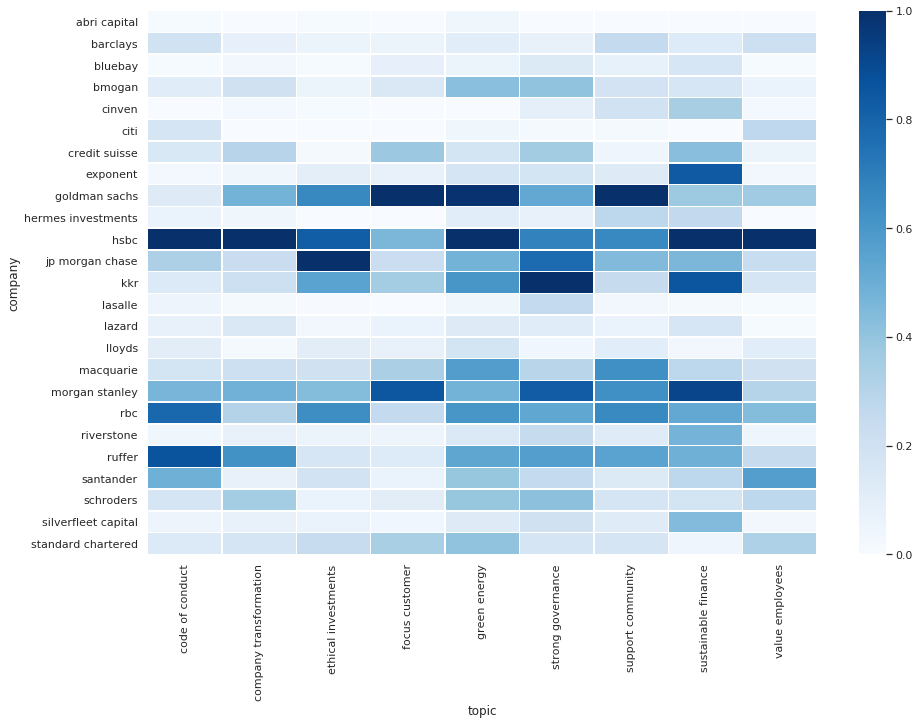

In [ ]:
# create a simple pivot table of number of occurence of each topic across organisations
esg_focus = pd.crosstab(esg_group.company, esg_group.topic)

# scale topic frequency between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))

# normalize pivot table
esg_focus_norm = pd.DataFrame(scaler.fit_transform(esg_focus), columns=esg_focus.columns)
esg_focus_norm.index = esg_focus.index

# plot heatmap, showing main area of focus for each FSI across topics we learned
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(esg_focus_norm, annot=False, linewidths=.5, cmap='Blues')
plt.show()

In [ ]:
%python
esg_focus_norm.reset_index(inplace= True)
esg_focus_norm_spark_df = spark.createDataFrame(esg_focus_norm)
esg_focus_norm_spark_df.select(col("company").alias("Company"),col("code of conduct").alias("CodeOfConduct"),col("company transformation").alias("CompanyTransformation"),col("value employees").alias("ValueEmployees"),col("sustainable finance").alias("SustainableFinance"),col("support community").alias("SupportCommunity"),col("strong governance").alias("StrongGovernance"),col("ethical investments").alias("EthicalInvestments"),col("focus customer").alias("FocusCustomer"),col("green energy").alias("GreenEnergy"))\
.write \
.mode("append") \
.format("delta") \
.saveAsTable("esg_db.srcEsgCompanyVsTopicProbability")

In [ ]:
%scala
import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger

//read data from source table
val streamDf = spark 
  .readStream                                                  // Reading as a stream, processing record since last check point
  .format("delta")                                              // Reading from a delta table
  .table("esg_db.srcEsgCompanyVsTopicProbability")  //Main source table
  .withColumn("IsMigrated", lit(0)) 

//Create a chekpoint of last insertion
streamDf
  .writeStream                                                                  // Writing data as a stream
  .trigger(Trigger.Once)                                                       // Create a streaming job triggered only once...
  .option("checkpointLocation", "/esg_checkpoint/dbrEsgSentimentVsMarketPerformance_4") //Don't change checkpoint location (processes data since last checkpoint)
  .format("delta")                                                              // write to delta table
  .table("esg_db.dbrEsgCompanyVsTopicProbability")   //Save to intermediary Databricks table

import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger
streamDf: org.apache.spark.sql.DataFrame = [Company: string, CodeOfConduct: double ... 9 more fields]
res3: org.apache.spark.sql.streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@54aa8ceb

In [ ]:
%sql
SELECT DISTINCT Company, IsMigrated FROM esg_db.dbrEsgCompanyVsTopicProbability

Company IsMigrated riverstone 0 rbc 0 ruffer 0 schroders 0 santander 0 silverfleet capital 0 standard chartered 0 kkr 0 lasalle 0 lazard 0 exponent 0 credit suisse 0 goldman sachs 0 jp morgan chase 0 hermes investments 0 hsbc 0 barclays 0 bluebay 0 abri capital 0 macquarie 0 lloyds 0 morgan stanley 0 bmogan 0 cinven 0 citi 0

In [ ]:
%scala
//Configuration settings to connect to blob storage
//spark.conf.set("fs.azure.account.key.#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net", "#STORAGE_ACCOUNT_KEY#"))

//val sqluser =  dbutils.secrets.get(scope="esgmigratecreds", key="sqluser")
//val sqlpassword = dbutils.secrets.get(scope="esgmigratecreds", key="sqlpassword")
//val dbtable = "ADB_EsgCompanyVsTopicProbability" //Synapse Table Name Set here
//val url = s"jdbc:sqlserver://#WORKSPACE_NAME#.sql.azuresynapse.net:1433;database=#DATABASE_NAME#;user=#SQL_USERNAME#;password=#SQL_PASSWORD#;encrypt=true;trustServerCertificate=true;hostNameInCertificate=*.sql.azuresynapse.net;loginTimeout=30;authentication=ActiveDirectoryPassword"

// //Read only newer records from our intermediary table in Databricks
// var migrate_df = spark.sql("SELECT Company as Organisation, CAST(CodeOfConduct AS DECIMAL(2,1)) AS CodeOfConduct,CAST(CompanyTransformation AS DECIMAL(2,1)) AS CompanyTransformation,CAST(ValueEmployees AS DECIMAL(2,1)) AS ValueEmployees,CAST(FocusCustomer AS DECIMAL(2,1)) AS FocusCustomer,CAST(SustainableFinance AS DECIMAL(2,1)) AS SustainableFinance,CAST(SupportCommunity AS DECIMAL(2,1)) AS SupportCommunity,CAST(StrongGovernance AS DECIMAL(2,1)) AS StrongGovernance,CAST(EthicalInvestments AS DECIMAL(2,1)) AS EthicalInvestments,CAST(GreenEnergy AS DECIMAL(2,1)) AS GreenEnergy, current_timestamp() as ReportedOn FROM esg_db.dbrEsgCompanyVsTopicProbability WHERE IsMigrated = 0")
 
// print(s"Total Records", migrate_df.count())
// print("\n")

// //Send new records to synapse for further processing
// migrate_df.write.format("com.databricks.spark.sqldw").option("forwardSparkAzureStorageCredentials", "true").mode("append").option("url", url).option("dbtable", dbtable).option("tempDir", "abfss://esg-migrate@stfsimarketdatasynprod.dfs.core.windows.net/tempDirs").save()

// //Mark records as migrated after successfully saved to synapase
// spark.sql("UPDATE esg_db.dbrEsgCompanyVsTopicProbability SET IsMigrated = 1 WHERE IsMigrated = 0")

This matrix offers a quick lense through ESG strategies across FSIs. Whilst some companies would focus more on employees and peole (such as Royal Bank of Canada), some such as Goldman Sachs or KKR put a slightly more focus on ethical investments.

In [ ]:
# not every statement follows a well defined topic
# some statements may be more generic and span across multiple themes
esg_group.probability.hist(bins=50, figsize=(10,8), color='steelblue')

# plot distribution of main topic proability
plt.axvline(0.89, color='coral', linestyle='--')
plt.title('Primary topic distribution')
plt.xlabel('probability')
plt.ylabel('density')
plt.show()

Only some statements are specific to one distinct topic. Applying threshold of 0.9, we have ~20% of statements that are specific to our topics.
We'll apply this threshold to extract topic specific statements answering questions like *"What actions bank XXX really followed to support local communities?"*

In [ ]:
# extract statements relevant to a given topic
topic_discussions = esg_group[esg_group['topic'] == 'value employees']

# as specified in probability distribution, we want only specific topics and not general discussions
topic_discussions = topic_discussions[topic_discussions['probability'] > 0.89]

# access more specific topics first
topic_discussions = topic_discussions.sort_values('probability', ascending=False)

rows = [] 
for i, row in topic_discussions.iterrows():
  rows.append([row.company, row.probability, row.statement])

# display dataframe of statements for selected topic of interest
display(pd.DataFrame(rows, columns=['company', 'probability', 'statement']))

## `STEP3`: Key ESG initiatives
In previous step, we have used a Latent Dirichlet allocation to extract topics from our 7200 large corpus documents. This would return a probability distribution for each statement to cover each of the 9 defined topics. Although this offers a great lense in how we summarize ESG reports programmatically, it does not say much about the specificity of a statement in one organisation compare to others. In other words, we cannot distinguish what are general terms being discussed compare to companies specific ESG strategies. Our goal is to use the probability distribution from LDA as input vector to a superseding clustering algorithm ([KMeans](https://en.wikipedia.org/wiki/K-means_clustering) in that case). By grouping statements into similar buckets, we will be able to access the relevance of a ESG statement with regards to how it deviates from the norm. This approach - similar to anomaly detection - will return the key strategic initiatives for each organisation.

In [ ]:
# we extract our probabilities distribution as input vectors for KMeans
X_train = list(esg_group.probabilities)

# nevertheless, we still want to ensure relavance of our clustering using the simple "elbow method"
# we capture the sum of squared distance of each point to their closest center for different values of k
wsses = []
for k in [5, 8, 10, 20, 30, 50, 80, 100]:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_train)
  wsse = np.sum([np.min(x)**2 for x in kmeans.transform(X_train)]) 
  wsses.append([k, wsse])
  
# we simply plot the WSSE against K to find optimal K value
wsse_df = pd.DataFrame(wsses, columns=['k', 'wsse'])
display(wsse_df)

This simple methods shows that our ideal number of clusters to group similar statements should be around 15-20.

In [ ]:
# track experiment on MLflow
with mlflow.start_run(run_name='clustering'):
  
  # we train our KMeans model trained with the appropriate value for K
  kmeans = KMeans(n_clusters=20, random_state=42)
  kmeans.fit(X_train)
  
  # Log model 
  mlflow.sklearn.log_model(kmeans, "model")
  mlflow.log_param('n_clusters', '15')
  mlflow.log_metric('wsse', np.sum([np.min(x)**2 for x in kmeans.transform(X_train)]))
  
  # Retrieve experiment ID
  cluster_run_id = mlflow.active_run().info.run_id

In [ ]:
# find the minimum distance for each point to their closest cluster
y_dist = [np.min(x) for x in kmeans.transform(X_train)]
dist_df = pd.DataFrame(zip(y_dist), columns=['distance'])
esg_group_dist = pd.concat([esg_group, dist_df], axis=1)

In [ ]:
#given the cluster distance as relevance of a topic compare to competitors, we
#let that decision to end users to apply industry generic vs. companies specific thresholds via SQL functionalities
spark.createDataFrame(esg_group_dist) \
 .write \
 .format("delta") \
 .saveAsTable("esg_db.reports")

In [ ]:
%sql

SELECT 
  t.company,
  t.topic,
  t.statement
FROM (
  SELECT 
    e.company,
    e.topic,
    e.probability,
    e.distance,
    LOWER(e.statement) AS statement,
    dense_rank() OVER (PARTITION BY e.company, e.topic ORDER BY e.distance DESC) as rank
  FROM esg_db.reports e
) t
WHERE t.rank = 1
AND t.topic IN ('green energy')
ORDER BY company, topic, rank

In [ ]:
%sql

WITH ranked (
  SELECT 
    e.topic, 
    e.statement, 
    e.company,
    dense_rank() OVER (PARTITION BY e.company, e.topic ORDER BY e.probability DESC) as rank
  FROM esg_db.reports e
)

SELECT 
  t.topic,
  t.statement
FROM ranked t
WHERE t.company = 'goldman sachs' 
AND t.rank = 1

In [ ]:
%sql
CREATE TABLE esg_db.srcEsgOrganisation USING delta AS
SELECT DISTINCT Company FROM esg_db.srcEsgCompanyVsTopicProbability

In [ ]:
%scala
import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger

//read data from source table
val streamDf = spark 
  .readStream                                                  // Reading as a stream, processing record since last check point
  .format("delta")                                              // Reading from a delta table
  .table("esg_db.srcEsgOrganisation")  //Main source table
  .withColumn("IsMigrated", lit(0)) 

//Create a chekpoint of last insertion
streamDf
  .writeStream                                                                  // Writing data as a stream
  .trigger(Trigger.Once)                                                       // Create a streaming job triggered only once...
  .option("checkpointLocation", "/esg_checkpoint/dbrEsgOrganisation_1") //Don't change checkpoint location (processes data since last checkpoint)
  .format("delta")                                                              // write to delta table
  .table("esg_db.dbrEsgOrganisation")   //Save to intermediary Databricks table

import org.apache.spark.sql.functions._
import org.apache.spark.sql.streaming.Trigger
streamDf: org.apache.spark.sql.DataFrame = [Company: string, IsMigrated: int]
res5: org.apache.spark.sql.streaming.StreamingQuery = org.apache.spark.sql.execution.streaming.StreamingQueryWrapper@18e633b0

In [ ]:
%scala
//Configuration settings to connect to blob storage
//spark.conf.set("fs.azure.account.key.#STORAGE_ACCOUNT_NAME#.dfs.core.windows.net","#STORAGE_ACCOUNT_KEY#"))

//val sqluser =  dbutils.secrets.get(scope="esgmigratecreds", key="sqluser")
//val sqlpassword = dbutils.secrets.get(scope="esgmigratecreds", key="sqlpassword")
//val dbtable = "ADB_EsgOrganisation" //Synapse Table Name Set here
//val url = s"jdbc:sqlserver://#WORKSPACE_NAME#.sql.azuresynapse.net:1433;database=#DATABASE_NAME#;user=#SQL_USERNAME#;password=#SQL_PASSWORD#;encrypt=true;trustServerCertificate=true;hostNameInCertificate=*.sql.azuresynapse.net;loginTimeout=30;authentication=ActiveDirectoryPassword"

// //Read only newer records from our intermediary table in Databricks
// var migrate_df = spark.sql("SELECT Company AS Organisation FROM esg_db.dbrEsgOrganisation WHERE IsMigrated = 0")
 
// print(s"Total Records", migrate_df.count())
// print("\n")

// //Send new records to synapse for further processing
// migrate_df.write.format("com.databricks.spark.sqldw").option("forwardSparkAzureStorageCredentials", "true").mode("append").option("url", url).option("dbtable", dbtable).option("tempDir", "abfss://esg-migrate@stfsimarketdatasynprod.dfs.core.windows.net/tempDirs").save()

// //Mark records as migrated after successfully saved to synapase
// spark.sql("UPDATE esg_db.dbrEsgOrganisation SET IsMigrated = 1 WHERE IsMigrated = 0")

Using NLP techniques to summarize a series of complex PDF documents into key statements and extract key initiatives, we can now provide these insights to asset managers and risk officers as a form of a MI report we later enrich with news analytics data